Story:
X company manufactures and sells two types of products: basic and premium. The
basic products are sold at a consistent rate, but the premium products only start selling well
once a certain threshold in marketing expenditure is reached. Initially, increasing marketing
expenditure has a small effect on sales, but once the threshold is crossed, the sales increase
significantly.

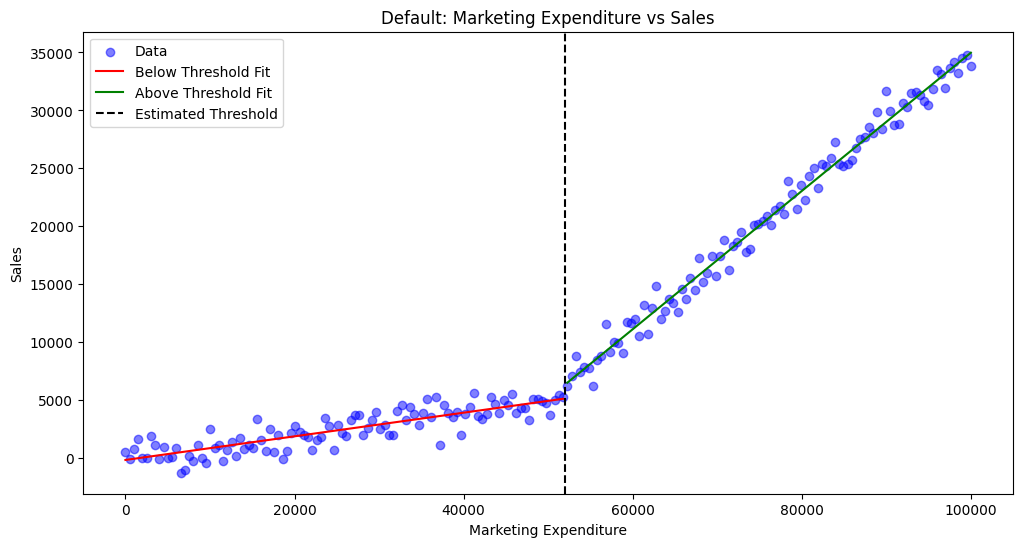

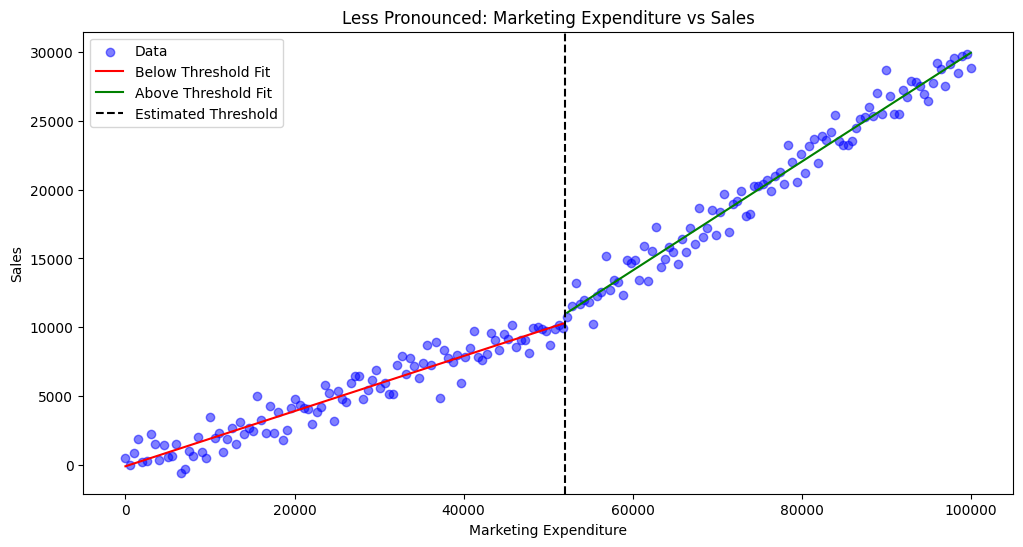

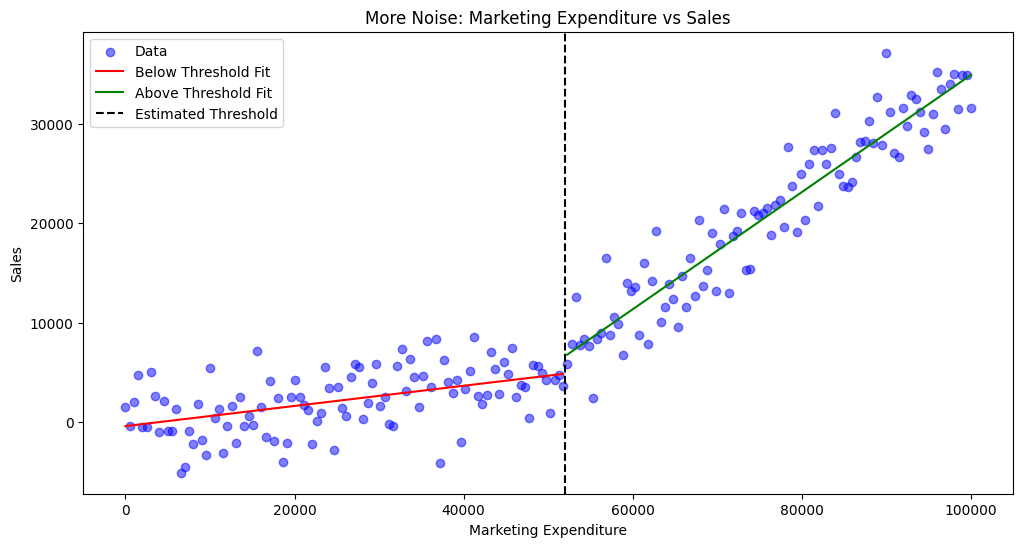

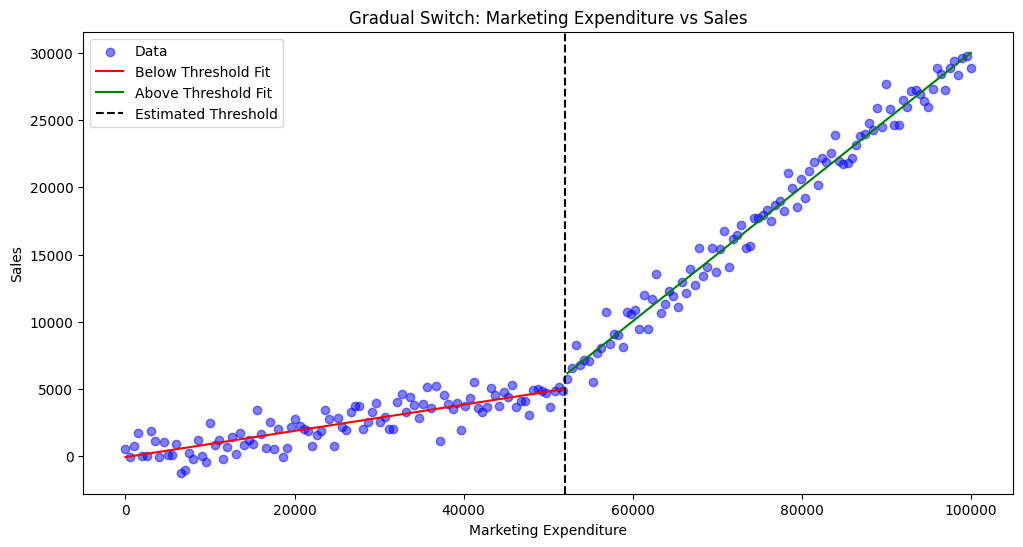

(52020.20202020202, 52020.20202020202, 52020.20202020202, 52020.20202020202)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Function to generate data
def generate_data(threshold, less_pronounced=False, more_noise=False, gradual_switch=False):
    np.random.seed(42)
    marketing_expenditure = np.linspace(0, 100000, 200)
    
    if less_pronounced:
        sales = np.piecewise(
            marketing_expenditure,
            [marketing_expenditure < threshold, marketing_expenditure >= threshold],
            [lambda x: 10 + 0.2*x + np.random.normal(0, 1000, len(x)), 
             lambda x: 10 + 0.2*x + 0.2*(x - threshold) + np.random.normal(0, 1000, len(x))]
        )
    elif more_noise:
        sales = np.piecewise(
            marketing_expenditure,
            [marketing_expenditure < threshold, marketing_expenditure >= threshold],
            [lambda x: 10 + 0.1*x + np.random.normal(0, 3000, len(x)), 
             lambda x: 10 + 0.1*x + 0.5*(x - threshold) + np.random.normal(0, 3000, len(x))]
        )
    elif gradual_switch:
        def gradual_transition(x, threshold=50000):
            return 0.5 * (1 + np.tanh((x - threshold) / 5000))
        
        sales = 10 + 0.1 * marketing_expenditure + 0.4 * (marketing_expenditure - threshold) * gradual_transition(marketing_expenditure) + np.random.normal(0, 1000, len(marketing_expenditure))
    else:
        sales = np.piecewise(
            marketing_expenditure,
            [marketing_expenditure < threshold, marketing_expenditure >= threshold],
            [lambda x: 10 + 0.1*x + np.random.normal(0, 1000, len(x)), 
             lambda x: 10 + 0.1*x + 0.5*(x - threshold) + np.random.normal(0, 1000, len(x))]
        )
    
    return pd.DataFrame({'Marketing Expenditure': marketing_expenditure, 'Sales': sales})


def piecewise_model(data, candidate_switch_points):
    best_tau = None
    best_error = float('inf')
    best_model_below = None
    best_model_above = None

    for tau in candidate_switch_points:
        below_threshold = data[data['Marketing Expenditure'] < tau]
        above_threshold = data[data['Marketing Expenditure'] >= tau]
        
        model_below = LinearRegression().fit(below_threshold[['Marketing Expenditure']], below_threshold['Sales'])
        model_above = LinearRegression().fit(above_threshold[['Marketing Expenditure']], above_threshold['Sales'])
        
        pred_below = model_below.predict(below_threshold[['Marketing Expenditure']])
        pred_above = model_above.predict(above_threshold[['Marketing Expenditure']])
        
        error_below = mean_squared_error(below_threshold['Sales'], pred_below)
        error_above = mean_squared_error(above_threshold['Sales'], pred_above)
        total_error = error_below * len(below_threshold) + error_above * len(above_threshold)
        
        if total_error < best_error:
            best_error = total_error
            best_tau = tau
            best_model_below = model_below
            best_model_above = model_above

    return best_tau, best_model_below, best_model_above


candidate_switch_points = np.linspace(10000, 90000, 100)


scenarios = {
    "Default": {},
    "Less Pronounced": {"less_pronounced": True},
    "More Noise": {"more_noise": True},
    "Gradual Switch": {"gradual_switch": True}
}

results = {}

for scenario, params in scenarios.items():
    data = generate_data(threshold=50000, **params)
    best_tau, best_model_below, best_model_above = piecewise_model(data, candidate_switch_points)
    
    below_threshold = data[data['Marketing Expenditure'] < best_tau]
    above_threshold = data[data['Marketing Expenditure'] >= best_tau]

    pred_below = best_model_below.predict(below_threshold[['Marketing Expenditure']])
    pred_above = best_model_above.predict(above_threshold[['Marketing Expenditure']])
    
    results[scenario] = {
        "data": data,
        "best_tau": best_tau,
        "below_threshold": below_threshold,
        "above_threshold": above_threshold,
        "pred_below": pred_below,
        "pred_above": pred_above
    }


for scenario, result in results.items():
    plt.figure(figsize=(12, 6))
    plt.scatter(result["data"]['Marketing Expenditure'], result["data"]['Sales'], color='blue', alpha=0.5, label='Data')
    plt.plot(result["below_threshold"]['Marketing Expenditure'], result["pred_below"], color='red', label='Below Threshold Fit')
    plt.plot(result["above_threshold"]['Marketing Expenditure'], result["pred_above"], color='green', label='Above Threshold Fit')
    plt.axvline(x=result["best_tau"], color='black', linestyle='--', label='Estimated Threshold')
    plt.xlabel('Marketing Expenditure')
    plt.ylabel('Sales')
    plt.title(f'{scenario}: Marketing Expenditure vs Sales')
    plt.legend()
    plt.show()

results['Default']['best_tau'], results['Less Pronounced']['best_tau'], results['More Noise']['best_tau'], results['Gradual Switch']['best_tau']

Above we can see the four plots. Let's comment on each of them:

1. Applying of two-part linear regression model where the model fits two separate
linear regressions to the data below and above the threshold.
2. The Difference Between the Two Parts Becomes Less Pronounced
3. Noise Increases
4. The Switch Occurs More Gradually

This implementation uses grid search to find the best switch point and fits separate linear
models to the segments of data before and after the switch point. It provides a way to
estimate the switch point without requiring Bayesian inference libraries.
The estimated switch point remains consistent around 52,020.20 across different scenarios:
(52020.20202020202, 52020.20202020202, 52020.20202020202, 52020.20202020202)

The grid search-based two-part linear model is robust in identifying the switch point and
adapting to different conditions in the data. It demonstrates flexibility in fitting scenarios
with varying degrees of noise, slope differences, and transition sharpness. This approach
provides a viable alternative to Bayesian methods for estimating piecewise linear models.